## Tópicos Especiais em Inteligência Artificial

## Classificação de diagnóstico de câncaer de mama com Deep Neural Network (DNN)

Neste trabalho vamos utilizar o dataset Breast Cancer Wisconsin (Diagnostic) disponível no repositório de datasets da UCI. Este é um conjunto de dados multivariado com atributos numéricos de ponto flutuante usado para classificação do tipo de câncer de mama de um paciente com: MALIGNO ou BENIGNO. O dataset mostra resultados de exames de 699 pacientes coletados entre 1989 e 1991. É composto de 11 atributos que são usados como entrada no modelo:

1. ID do paciente
2. Espessura (1-10)
3. Uniformidade de tamanho da célula (1-10)
4. Uniformidade de forma da célula (1-10)
5. Adeesão marginal (1-10)
6. Tamanho único epitelial da célula (1-10)
7. Quantidade de núcleos nus (1-10)
8. Cromatina (1-10)
9. Quantidade de núcleos normais (1-10)
10. Mitoses (1-10)  
11. [SAÍDA] Classificação (2 para indicar BENIGNO, 4 para indicar MALIGNO)

O dataset contém 458 amostras com:
- 65.5% de casos BENIGNOS
- 34.5% de casos MALIGNOS

## 1. Preparação do ambiente

In [15]:
#funcao para deixar o jupyter com celulas preenchendo a tela toda
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [16]:
#importacao de bibliotecas

#para exportar o requiriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #divisao dos conjuntos
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load #gera, exporta e usa (salva no HD)

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow.keras 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

In [17]:
import tensorflow as tf
import keras
print("Versão do Keras: ", keras.__version__)
print("Versão do TensorFlow:", tf.__version__)
print("GPUs disponíveis:", len(tf.config.list_physical_devices('GPU')) > 0)
print("GPU: ", tf.config.list_physical_devices('GPU'))

Versão do Keras:  2.15.0
Versão do TensorFlow: 2.15.0
GPUs disponíveis: True
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
#rotina para exportação da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'], #executando uma consulta a todas as bib do ambiente e guradando
                                capture_output = True, #dentro de resultado
                                text = True,
                                check = True)
        
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout) #escrevendo as bib dentro desse arquivo

        print('Arquivo exportado com sucesso!')
    except subprocess.CalledProcessError as e:
        print(f"Deu erro:{e}")

exportaRequirements()


Arquivo exportado com sucesso!


## 2. Importação do dataset

In [ ]:
#2 BENIGNO --- 4 MALIGNO
#cria um nome para cada coluna no dataset
col_names = ['ID', 'espessura', 'tam_celula' , 'forma_celula', 'adesao', 'tam_epitelial', 'nucleos_nus', 'cromatina'
            , 'nucleos_normais', 'mitoses', 'diagnostico']

#importacao do dataset
data = pd.read_csv('dataset/breast-cancer-wisconsin.csv', header=None, names=col_names)

#remove a coluna ID, pq ela nao sera usada para nada
data = data.drop('ID', axis=1) #axis 0 ou 1, 0 tira linha e 1 tira coluna

#substitui um campo '?' por NaN
data = data.replace('?', np.NaN)

#converte tudo para numero
data = data.astype(float)

#converte o codigo do diagnostico
data = data.assign(diagnostico=data['diagnostico'].replace({2: 0, 4:1})) #a coluna diagnostico onde tem 2 passa a ser 0 e 4 vira 1

#nomeia as entradas e saidas
x_names = data.columns[:-1].tolist() #pega todas as colunas (:) menos a última (-1)
y_names = data.columns[-1:].tolist() #pega a última coluna


In [22]:
data

,espessura,tam_celula,forma_celula,adesao,tam_epitelial,nucleos_nus,cromatina,nucleos_normais,mitoses,diagnostico
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0
695,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0
696,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1.0
697,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1.0


## 3. Configuração do Experimento

In [ ]:
#realizar interpolacao de dados (criacao de dados sinteticos - nesse caso vizinho mais proximo)
interp_exec = True

#realizar deteccao e substituicao de outliers
outliers_exec = True

#realizar normalizacao de dados
normalization = True

#realizar escalonamento de dados
scale_exec = True

#exportar os datasets tratados
export_frames = True

#gerar um novo modelo ou usar um pronto
new_model = True

## 4. Análise de Dados

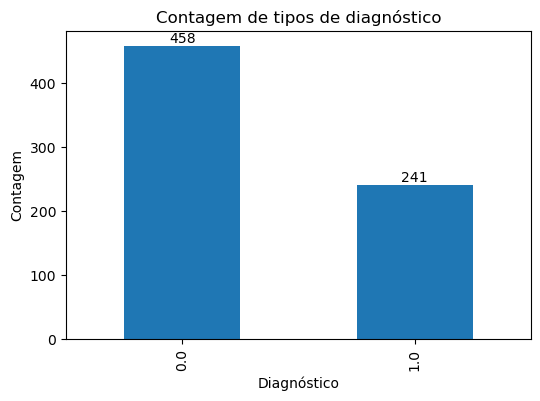

In [26]:
#contagem de diagnosticos
diag_counts = data['diagnostico'].value_counts()

#plota grafico de barra
plt.figure(figsize=(6,4))
diag_counts.plot(kind='bar')
plt.xlabel('Diagnóstico')
plt.ylabel('Contagem')
plt.title('Contagem de tipos de diagnóstico')

#adiciona os rotulos
for i, count in enumerate(diag_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.1 Sumarização estatística

In [35]:
def sumarizacao(data):
    stats = []

    for column in x_names:
        values = data[column]

        maximum = round(values.max(), 2) #arredonda o valor maximo da coluna no momento com duas casas decimais
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)
        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Coluna', 'Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']

    table = tabulate(stats, headers, tablefmt='pipe')
    print(table)

sumarizacao(data)

| Coluna          |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|:----------------|---------:|---------:|--------:|----------:|----------------:|
| espessura       |       10 |        1 |    4.42 |         4 |            2.82 |
| tam_celula      |       10 |        1 |    3.13 |         1 |            3.05 |
| forma_celula    |       10 |        1 |    3.21 |         1 |            2.97 |
| adesao          |       10 |        1 |    2.81 |         1 |            2.86 |
| tam_epitelial   |       10 |        1 |    3.22 |         2 |            2.21 |
| nucleos_nus     |       10 |        1 |    3.54 |         1 |            3.64 |
| cromatina       |       10 |        1 |    3.44 |         3 |            2.44 |
| nucleos_normais |       10 |        1 |    2.87 |         1 |            3.05 |
| mitoses         |       10 |        1 |    1.59 |         1 |            1.72 |


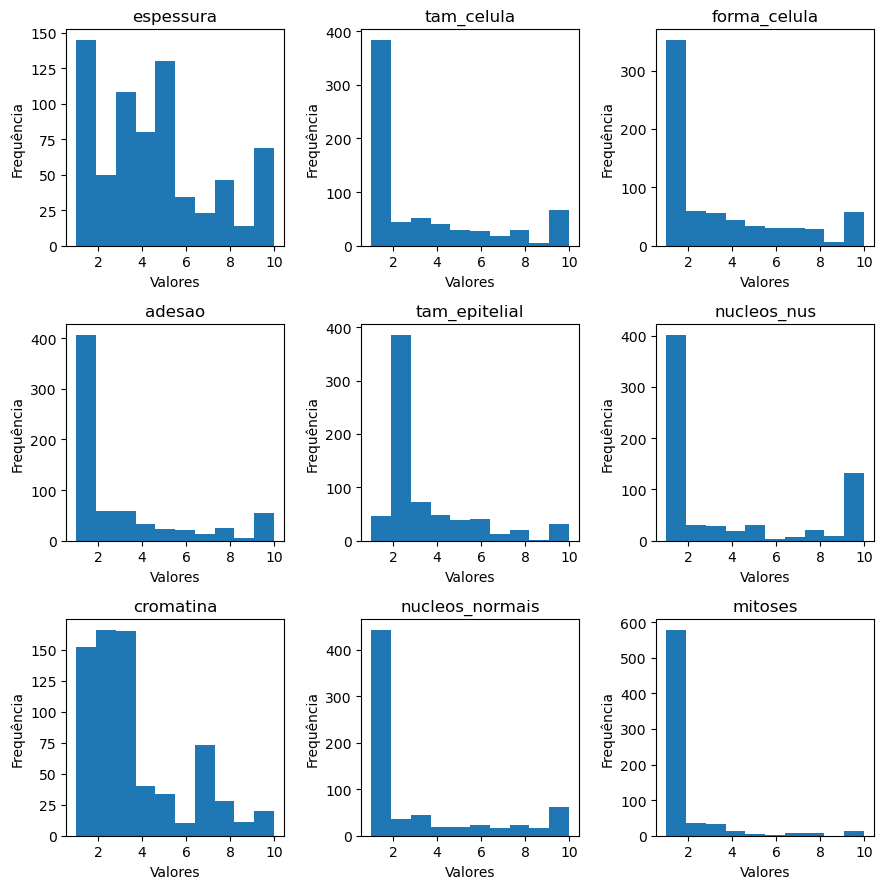

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9), tight_layout=True)

#pltar o grafico para cada coluna de entrada
for i, column in enumerate(x_names):
    row = i // 3 #linha atual
    col = i % 3 #coluna atual
    axs[row, col].hist(data[column], bins=10) #bins -> tamanho da classe do histograma
    axs[row, col].set_title(column)
    axs[row, col].set_xlabel('Valores')
    axs[row, col].set_ylabel('Frequência')

plt.show()

In [ ]:
#boxplot para ver se tem outliers (IQR)
data.boxplot(column=x_names, by='diagnostico', figsize=(12, 12)) #by = separar por diagnostico
plt.tight_layout()
plt.show()